In [1]:
!ls processed

X_combined_sparse.npz     X_tfidf.npz
X_nrc_features_scaled.npy y.npy


In [2]:
data_dir='processed'
X_combined_dataset_sparse_file='X_combined_sparse.npz'
y_sampled_file='y.npy'

In [3]:
import numpy as np
from os import path
from scipy.sparse import load_npz
import pandas as pd

X_combined_dataset = load_npz(path.join(data_dir, X_combined_dataset_sparse_file))
y_resampled=np.load(path.join(data_dir, y_sampled_file))
y_resampled=pd.Series(y_resampled)

In [4]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X_combined_dataset, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(f'X_train shape: {X_train_val.shape}')
print(f'y_train shape: {y_train_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

print(f'y_train count:\n{y_train_val.value_counts()}')
print(f'y_test count:\n{y_test.value_counts()}')

X_train shape: (79672, 5010)
y_train shape: (79672,)
X_test shape: (19918, 5010)
y_test shape: (19918,)
y_train count:
0    46724
1    32948
Name: count, dtype: int64
y_test count:
0    11681
1     8237
Name: count, dtype: int64


In [5]:
import numpy as np
from os import path
from scipy.sparse import load_npz
import pandas as pd
import tensorflow as tf

class SparseDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x, y, batch_size=32, shuffle=True): # Added shuffle
        'Initialization'
        self.batch_size = batch_size
        self.x = x
        self.y = y
        self.shuffle = shuffle # Store shuffle preference

        # --- FIX 1: Use .shape[0] ---
        self.indexes = np.arange(self.x.shape[0])

        # --- FIX 3: Add on_epoch_end and call it ---
        self.on_epoch_end() # Perform initial shuffle

    def __len__(self):
        'Denotes the number of batches per epoch'
        # --- FIX for inconsistent sample count: return ceil of division to include last batch ---
        return int(np.ceil(self.x.shape[0] / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # --- FIX for inconsistent sample count: adjust slicing for the last batch ---
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, self.x.shape[0])
        indexes = self.indexes[start_index:end_index]


        # Find list of IDs
        x_batch_sparse = self.x[indexes]
        y_batch = self.y[indexes]

        # --- FIX 2: THIS IS THE MOST IMPORTANT LINE ---
        # It solves your RAM problem by only converting the small batch
        x_batch_dense = x_batch_sparse.toarray()
        # (Using .toarray() is generally preferred over .todense())

        return x_batch_dense, y_batch

    # --- FIX 3: Added this required method ---
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_val_resampled, y_train_val_resampled = ros.fit_resample(X_train_val, y_train_val)
print(f'X_train_val_resampled shape: {X_train_val_resampled.shape}')
print(f'y_train_val_resampled shape: {y_train_val_resampled.shape}')
print(f'y_train_val_resampled count:\n{y_train_val_resampled.value_counts()}')

X_train_val_resampled shape: (93448, 5010)
y_train_val_resampled shape: (93448,)
y_train_val_resampled count:
1    46724
0    46724
Name: count, dtype: int64


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_resampled, y_train_val_resampled, test_size=0.2, stratify=y_train_val_resampled, random_state=42)

# Convert pandas Series to numpy arrays for consistent indexing in the generator
train_generator = SparseDataGenerator(X_train, y_train.to_numpy(), batch_size=32)
test_generator = SparseDataGenerator(X_test, y_test.to_numpy())
val_generator = SparseDataGenerator(X_val, y_val.to_numpy(), batch_size=32)
train_val_generator = SparseDataGenerator(X_train_val_resampled, y_train_val_resampled, batch_size=32)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],))) # Input layer matching the number of features

    # Add number of layers between 1, 3
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
      model.add(
          layers.Dense(units=hp.Int(f'units_hidden_{i}', min_value=32, max_value=512, step=32), activation=hp.Choice(f'activation_hidden_{i}', values=['relu', 'tanh'])))
      model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    if optimizer_choice == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
      optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [9]:
from keras_tuner import Hyperband
PROJECT_NAME='reddit_mlp_combined_cleaned_hyperband'
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='keras_mlp',
    project_name=PROJECT_NAME
)


2025-11-07 01:02:01.326291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-07 01:02:01.326315: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-07 01:02:01.326321: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-07 01:02:01.326340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-07 01:02:01.326350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stopping])

Trial 30 Complete [00h 03m 20s]
val_accuracy: 0.8828785419464111

Best val_accuracy So Far: 0.8870518803596497
Total elapsed time: 00h 46m 31s


In [11]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = build_model(best_hps)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 320)            │     1,603,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 288)            │        92,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,696,257 (6.47 MB)

 Trainable params: 1,696,257 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8462 - loss: 0.3720 - val_accuracy: 0.8682 - val_loss: 0.3363
Epoch 2/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8735 - loss: 0.3163 - val_accuracy: 0.8697 - val_loss: 0.3209
Epoch 3/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8851 - loss: 0.2937 - val_accuracy: 0.8791 - val_loss: 0.3131
Epoch 4/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8921 - loss: 0.2803 - val_accuracy: 0.8758 - val_loss: 0.3088
Epoch 5/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8980 - loss: 0.2687 - val_accuracy: 0.8848 - val_loss: 0.2984
Epoch 6/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9033 - loss: 0.2608 - val_accuracy: 0.8864 - val_loss: 0.2994
Epoch 7/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9068 - loss: 0.2531 - val_accuracy: 0.8867 - val_loss: 0.3110
Epoch 8/200
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9103 -

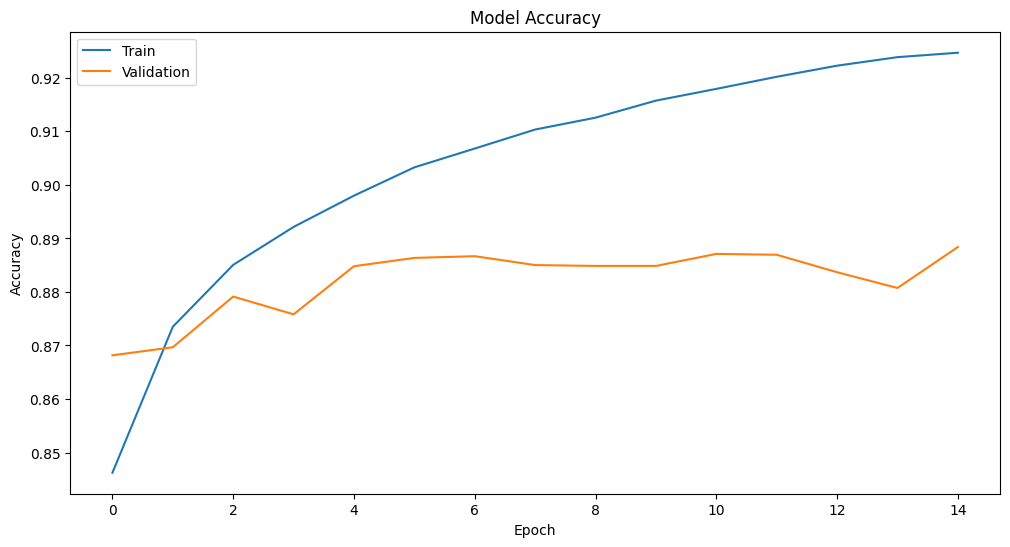

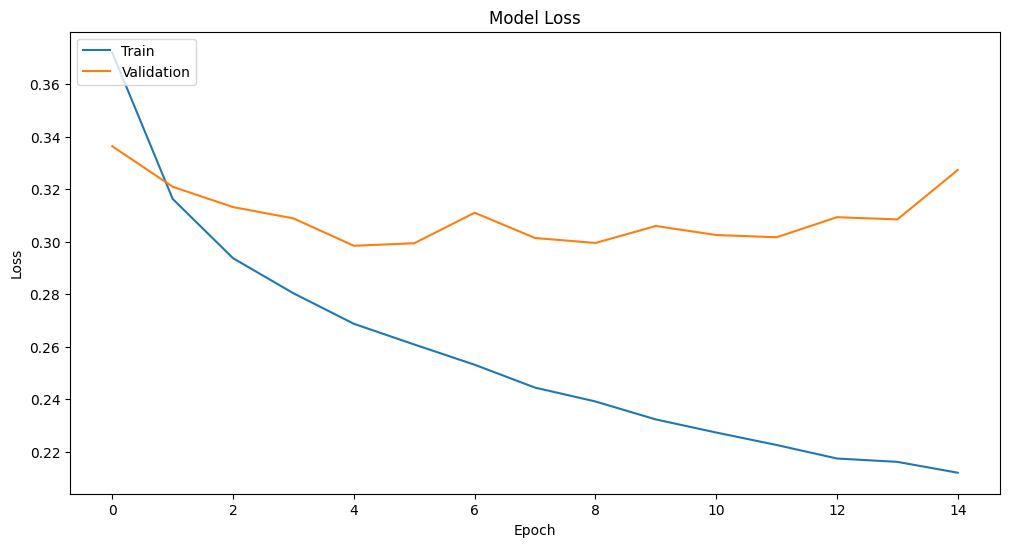

In [12]:
import matplotlib.pyplot as plt

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the best hyperparameters to get the training history
# Use the generators for training and validation
history = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[early_stop])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
best_epoch_num = np.argmin(history.history['val_loss']) + 1

print(f'Best epoch found: {best_epoch_num}')

final_model = build_model(best_hps)

final_model.fit(train_val_generator, epochs=best_epoch_num, verbose=True)

Best epoch found: 5
Epoch 1/5
 270/2921 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7881 - loss: 0.4683

2921/2921 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8493 - loss: 0.3660
Epoch 2/5
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8768 - loss: 0.3116
Epoch 3/5
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8868 - loss: 0.2911
Epoch 4/5
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8933 - loss: 0.2788
Epoch 5/5
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8983 - loss: 0.2688


In [14]:
# Evaluate the model on the test data
# Make sure to use the test_generator here
loss, accuracy = final_model.evaluate(SparseDataGenerator(X_test, y_test.to_numpy(), batch_size=32))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

 34/623 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9035 - loss: 0.2857

/Users/dark/code/project/depression/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8694 - loss: 0.3236
Test Loss: 0.3236
Test Accuracy: 0.8694


136/623 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/dark/code/project/depression/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     11681
           1       0.83      0.86      0.84      8237

    accuracy                           0.87     19918
   macro avg       0.86      0.87      0.87     19918
weighted avg       0.87      0.87      0.87     19918



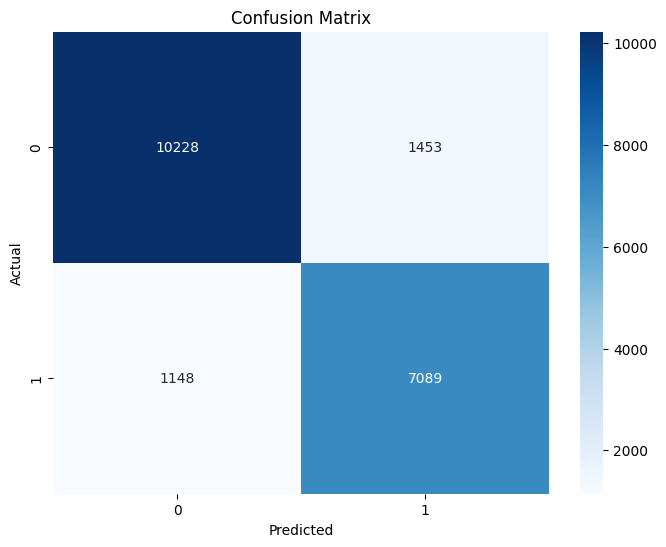

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the test set
# Use the test_generator to get batches and predict on each batch
y_pred_probs = final_model.predict(SparseDataGenerator(X_test, y_test.to_numpy(), batch_size=32, shuffle=False)) # Set shuffle to False for consistent order
y_pred = (y_pred_probs > 0.5).astype("int32") # Convert probabilities to binary predictions

# Flatten the predictions if necessary (depends on the output shape of your model)
y_pred = y_pred.flatten()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

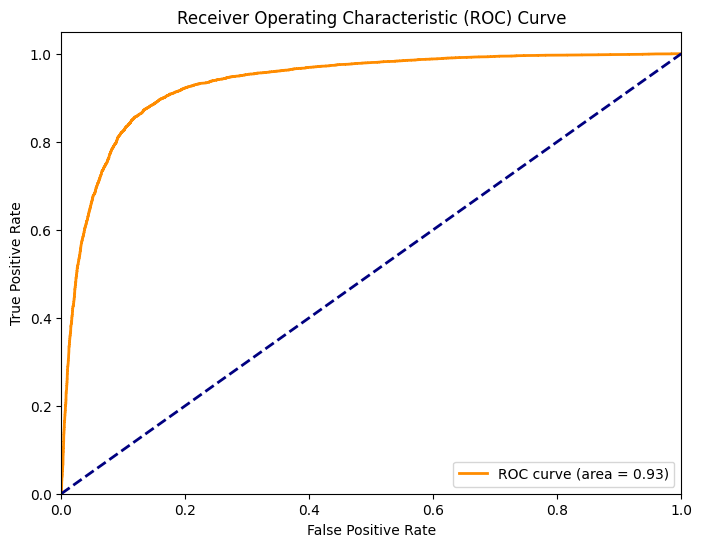

In [16]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

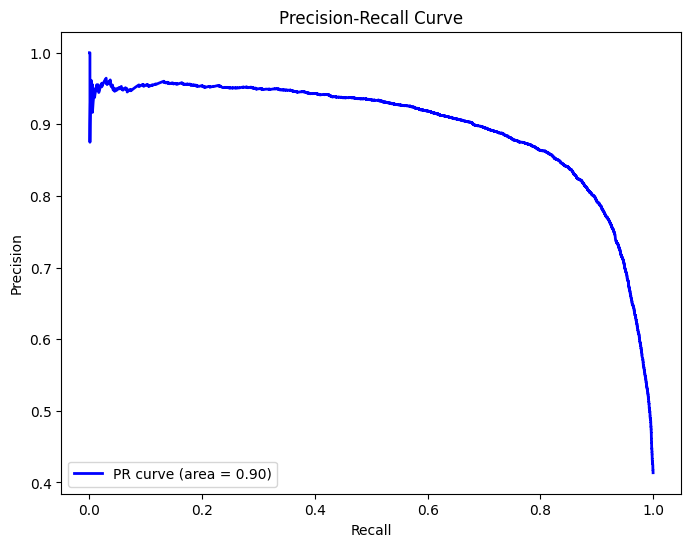

In [17]:
# Calculate PR curve and Average Precision
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
average_precision = average_precision_score(y_test, y_pred_probs)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [18]:
import os
model_directory='models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_name=f'{PROJECT_NAME}.keras'
final_model.save(path.join(model_directory, model_name))